In [107]:
import struct
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as f
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt
from math import log
import numpy as np
from scipy.optimize import curve_fit

# Setting

In [2]:
spark = SparkSession.builder \
            .master("spark://10.67.22.4:7077") \
            .appName("Project") \
            .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.2.0')\
            .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')\
            .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.11.375')\
            .config("spark.executor.memory", "2g")\
            .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
            .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
            .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
            .config('spark.hadoop.fs.s3a.access.key', '2186eedc366545058b0896dadf79d288')\
            .config('spark.hadoop.fs.s3a.secret.key', 'de147ce2e90741cdb9bae8f53ee5466e')\
            .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
            .config("com.amazonaws.sdk.disableCertChecking","true") \
            .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.amazonaws#aws-java-sdk added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-649d6608-297d-444e-9db1-5c1db53806f9;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk;1.11.375 in central
	found com.amazonaws#aws-java-sdk-dlm;1.11.375 in central
	found com.amazonaws#aws-java-sdk-core;1.11.375 in central
	found commons-logging#commons-logging;1.1.3 in central
	found org.apache.httpcomponents#httpclient;4.5.5 in central
	found org.apache.httpcomponents#httpcore;4.4.9 in central
	found commons-codec#commons-codec;1.10 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.core#jackson-databind;2.6.7.1 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.6.0 in central
	found com.fasterxml.jackson.core#jackson-core;2.6.7 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.6.7 in

	found com.amazonaws#aws-java-sdk-rekognition;1.11.375 in central
	found com.amazonaws#aws-java-sdk-polly;1.11.375 in central
	found com.amazonaws#aws-java-sdk-lightsail;1.11.375 in central
	found com.amazonaws#aws-java-sdk-stepfunctions;1.11.375 in central
	found com.amazonaws#aws-java-sdk-health;1.11.375 in central
	found com.amazonaws#aws-java-sdk-costandusagereport;1.11.375 in central
	found com.amazonaws#aws-java-sdk-codebuild;1.11.375 in central
	found com.amazonaws#aws-java-sdk-appstream;1.11.375 in central
	found com.amazonaws#aws-java-sdk-shield;1.11.375 in central
	found com.amazonaws#aws-java-sdk-batch;1.11.375 in central
	found com.amazonaws#aws-java-sdk-lex;1.11.375 in central
	found com.amazonaws#aws-java-sdk-mechanicalturkrequester;1.11.375 in central
	found com.amazonaws#aws-java-sdk-organizations;1.11.375 in central
	found com.amazonaws#aws-java-sdk-workdocs;1.11.375 in central
	found com.amazonaws#aws-java-sdk-models;1.11.375 in central
	found com.amazonaws#aws-java-s

22/07/04 13:52:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark

In [4]:
sc = spark.sparkContext
sc

<SparkContext master=spark://10.67.22.4:7077 appName=Project>

# Preprocessing data

### Load data

In [5]:
raw = spark.read.format("binaryFile").load('s3a://mapd-minidt-batch/data_*.dat')
raw = raw.select("content").rdd.flatMap(lambda el: el)

22/07/04 13:53:01 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


### Unpack data

In [6]:
def unpack(file_content):
    ppd = []
    word_counter=0
    word_size = 8                                             # size of the word in bytes
    for i in range(0, len(file_content), word_size):
        word_counter+=1
        thisInt = struct.unpack('<q', file_content[i:i+word_size])[0]
        head = (thisInt >> 61) & 0x7
        
        if head == 2:
            fpga = (thisInt >> 58) & 0x7
            chan = (thisInt >> 49) & 0x1FF
            orbit = (thisInt >> 17) & 0xFFFFFFFF
            bx = (thisInt >> 5 ) & 0xFFF
            tdc = (thisInt >> 0 ) & 0x1F
            ppd.append([fpga, chan, orbit, bx, tdc])
    return ppd

In [7]:
data = raw.flatMap(lambda file_content: unpack(file_content)).toDF(('FPGA','CHAN','ORBIT','BX','TDC'))
#data = data.persist()

### Locate chamber

In [8]:
data = data.withColumn("CHAMBER", when((data.FPGA==0) & (data.CHAN < 63), 0)\
                                    .when((data.FPGA==0) & (data.CHAN > 63) & (data.CHAN < 128), 1)\
                                    .when((data.FPGA==1) & (data.CHAN < 63), 2)\
                                    .when((data.FPGA==1) & (data.CHAN > 63) & (data.CHAN < 128), 3)\
                                    .when((data.FPGA==1) & (data.CHAN == 128), 4))
data = data.where(data.CHAMBER.isNotNull())

In [9]:
data = data.persist()

In [10]:
data.show(5)

+----+----+-------+----+---+-------+
|FPGA|CHAN|  ORBIT|  BX|TDC|CHAMBER|
+----+----+-------+----+---+-------+
|   1|  11|5797423| 432|  8|      2|
|   1|  12|5797423| 431|  9|      2|
|   1|  81|5797433|1889| 30|      3|
|   1|  98|5797443| 494| 18|      3|
|   0|  34|5797432|2379|  2|      0|
+----+----+-------+----+---+-------+
only showing top 5 rows



In [11]:
data = data.unpersist()

### Time information

In [15]:
data = data.withColumn('T_HIT_ns', (25 * (col('ORBIT') * 3564 + col('BX') + col('TDC')/30)))

In [16]:
data = data.persist()

In [17]:
data.show(5)

+----+----+-------+----+---+-------+--------------------+
|FPGA|CHAN|  ORBIT|  BX|TDC|CHAMBER|            T_HIT_ns|
+----+----+-------+----+---+-------+--------------------+
|   1|  11|5797423| 432|  8|      2|5.165504001066667E11|
|   1|  12|5797423| 431|  9|      2|   5.165504000825E11|
|   1|  81|5797433|1889| 30|      3|     5.1655132755E11|
|   1|  98|5797443| 494| 18|      3|5.165521836649999...|
|   0|  34|5797432|2379|  2|      0|5.165512506766666E11|
+----+----+-------+----+---+-------+--------------------+
only showing top 5 rows



In [18]:
data = data.unpersist()

#### Time corrections

In [19]:
data = data.withColumn("T_HIT_ns", when(data['CHAMBER']==0, data["T_HIT_ns"]+93.9)\
                                        .when(data['CHAMBER']==1, data["T_HIT_ns"]+101.4)\
                                        .when(data['CHAMBER']==2, data["T_HIT_ns"]+95.5)\
                                        .when(data['CHAMBER']==3, data["T_HIT_ns"]+92.4)\
                                        .when(data['CHAMBER']==4, data["T_HIT_ns"]))

In [20]:
data = data.persist()

In [21]:
data.show(5)

+----+----+-------+----+---+-------+--------------------+
|FPGA|CHAN|  ORBIT|  BX|TDC|CHAMBER|            T_HIT_ns|
+----+----+-------+----+---+-------+--------------------+
|   1|  11|5797423| 432|  8|      2|5.165504002021667E11|
|   1|  12|5797423| 431|  9|      2|    5.16550400178E11|
|   1|  81|5797433|1889| 30|      3|   5.165513276424E11|
|   1|  98|5797443| 494| 18|      3|5.165521837573999...|
|   0|  34|5797432|2379|  2|      0|5.165512507705666...|
+----+----+-------+----+---+-------+--------------------+
only showing top 5 rows



In [33]:
b = data.filter(data.CHAMBER==4).select(col("T_HIT_ns"))

In [34]:
b.show()

+--------------------+
|            T_HIT_ns|
+--------------------+
|    1.91469172155E11|
|2.900222310166666E11|
|3.418301146608333E11|
|3.505867889083334E11|
|3.649640720716667E11|
|4.477608862941667E11|
|4.789954560683333E11|
|    5.21193109325E11|
|    5.32976609105E11|
|    5.50708365855E11|
|6.197935512633334E11|
|   6.795325693175E11|
|    7.78636308425E11|
|   9.237240207475E11|
|9.595514739708334E11|
|1.054644621076666...|
|    1.12293779412E12|
|   1.166927980605E12|
|1.254460911740833...|
|1.326374104940833...|
+--------------------+
only showing top 20 rows



In [35]:
b.count()

5808

In [45]:
w = Window.partitionBy().orderBy('T_HIT_ns')
c = b.withColumn('lead', f.lag('T_HIT_ns', 1).over(w)) \
  .withColumn('t0_diff', f.when(f.col('lead').isNotNull(), f.col('T_HIT_ns') - f.col('lead')).otherwise(f.lit(None)))

In [46]:
c.show()

22/07/04 14:51:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 14:51:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 14:51:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 14:51:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 14:51:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 14:51:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 1

+--------------------+--------------------+--------------------+
|            T_HIT_ns|                lead|             t0_diff|
+--------------------+--------------------+--------------------+
|1.109461952958333...|                null|                null|
|1.115736637783333...|1.109461952958333...|       6.274684825E8|
|     1.3444942327E11|1.115736637783333...|2.287575949166667E10|
|1.486810697591666...|     1.3444942327E11|1.423164648916665...|
|1.541641142233333...|1.486810697591666...| 5.483044464166687E9|
|1.580121631833333E11|1.541641142233333...|3.8480489599999695E9|
|     1.6110728621E11|1.580121631833333E11| 3.095123026666687E9|
|1.675070365608333...|     1.6110728621E11|6.3997503508333435E9|
|    1.68713943115E11|1.675070365608333...|1.2069065541666565E9|
|1.700035598416667E11|    1.68713943115E11| 1.289616726666687E9|
|     1.8119385019E11|1.700035598416667E11|1.119029034833331...|
|1.888969135191666...|     1.8119385019E11|7.7030633291666565E9|
|    1.90122426465E11|1.8

In [53]:
d = c.select("t0_diff").toPandas()

22/07/04 15:00:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 15:00:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 15:00:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 15:00:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 15:00:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 15:00:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/04 1

(array([1.16803528e-10, 5.30857299e-11, 2.52558251e-11, 1.14154837e-11,
        5.74504737e-12, 2.27563565e-12, 9.69943062e-13, 7.46110048e-13,
        1.11916507e-13, 1.11916507e-13, 7.46110048e-14, 0.00000000e+00,
        0.00000000e+00, 3.73055024e-14]),
 array([1.51666016e+02, 4.61610092e+09, 9.23220169e+09, 1.38483025e+10,
        1.84644032e+10, 2.30805040e+10, 2.76966048e+10, 3.23127055e+10,
        3.69288063e+10, 4.15449071e+10, 4.61610078e+10, 5.07771086e+10,
        5.53932094e+10, 6.00093102e+10, 6.46254109e+10]),
 <BarContainer object of 14 artists>)

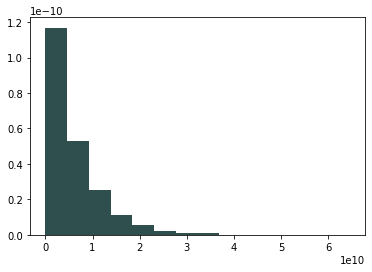

In [95]:
plot = plt.hist(d.t0_diff, bins=14, color='darkslategray', density=True)
plot

In [129]:
hist_val, bin_edges = np.histogram(d.t0_diff.dropna(), bins=14, density=True)
middle_edges = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

def exponential(x,A,gamma,c):
    return A*np.exp(-gamma*x)+c

par, cov = curve_fit(exponential, middle_edges, hist_val, p0=(2,1,0), method='lm')
print(par)
print(cov)

[2.00000000e+00 1.00000000e+00 1.54737895e-11]
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]


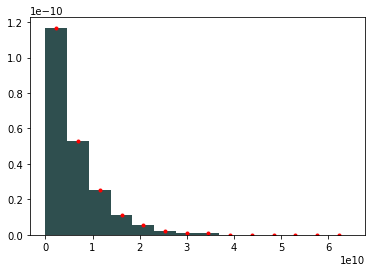

In [121]:
plt.plot(middle_edges,hist_val,'r.')
plot = plt.hist(d.t0_diff, bins=14, color='darkslategray', density=True)

In [22]:
data.createOrReplaceTempView("data_table")
data = spark.sql("SELECT * \
                    FROM (SELECT * FROM data_table WHERE ORBIT IN (SELECT DISTINCT ORBIT FROM data_table WHERE CHAMBER==4)) \
                    WHERE ORBIT IN (SELECT DISTINCT ORBIT \
                                    FROM (SELECT ORBIT, COUNT(*) AS COUNT \
                                           FROM data_table \
                                           GROUP BY (ORBIT) \
                                           HAVING count < 10))")

In [23]:
a = data.filter(data.CHAMBER==4).groupBy('ORBIT', 'CHAMBER').count()     \
        .select(col('ORBIT'), col('CHAMBER'), col('count').alias('CountCHAMBER4'))

In [24]:
a[a.CountCHAMBER4>1].show()

+---------+-------+-------------+
|    ORBIT|CHAMBER|CountCHAMBER4|
+---------+-------+-------------+
|228944101|      4|            2|
|223606439|      4|            2|
|237675632|      4|            2|
|372019954|      4|            2|
|237637945|      4|            2|
| 75838348|      4|            2|
|329713049|      4|            2|
| 82439580|      4|            2|
|286203450|      4|            2|
|383989265|      4|            2|
| 96367388|      4|            2|
|112916608|      4|            2|
|309217856|      4|            2|
| 90456706|      4|            2|
|175584122|      4|            2|
|209204100|      4|            2|
| 83827800|      4|            2|
|100941681|      4|            2|
|152433799|      4|            2|
+---------+-------+-------------+



In [25]:
a[a.CountCHAMBER4>1].count()

19

In [26]:
data.count()

41448

In [27]:
a2 = a.groupBy('CountCHAMBER4').count()

In [28]:
a2.show()

+-------------+-----+
|CountCHAMBER4|count|
+-------------+-----+
|            1| 5770|
|            2|   19|
+-------------+-----+



In [29]:
a[a.CountCHAMBER4==3].show()

+-----+-------+-------------+
|ORBIT|CHAMBER|CountCHAMBER4|
+-----+-------+-------------+
+-----+-------+-------------+

